# Using commuting projectors in STRUPHY

In STRUPHY the commuting projectors of the de Rham sequence are based on __inter-/histopolation__ of spline basis functions at Greville points. 

There are two kinds of projectors in STRUPHY:

* __global projectors__ based on inter-/histopolation in the __whole domain__ 
* __local projectors__ based on quasi-inter-/histopolation in a __neighbourhood of $x_i$__

In [ ]:
import numpy             as np
import matplotlib.pyplot as plt
import time
from sys import getsizeof

import hylife.utilitis_FEEC.projectors_global as proj_glob
import hylife.utilitis_FEEC.projectors_global_fastV3 as proj_glob_fastV3

import hylife.utilitis_FEEC.evaluation as eva
import hylife.utilitis_FEEC.evaluationV2 as evaV2
from hylife.utilitis_FEEC.linalg_kron import kron_matvec_3d


import hylife.utilitis_FEEC.bsplines as bsp

## Global projectors in 1D

Nel= 8
Nq= 6  0.0606482  0.0000000  |   0.0350961  0.0000000  |   0.0293687  0.0000000  | 
Nel= 16
Nq= 6  0.0215515  2.8141068  |   0.0105696  3.3204750  |   0.0081061  3.6230371  | 
Nel= 32
Nq= 6  0.0021679  9.9413679  |   0.0007974 13.2544025  |   0.0005994 13.5238667  | 
Nel= 64
Nq= 6  0.0002560  8.4686220  |   0.0000857  9.3034906  |   0.0000633  9.4714750  | 
Nel= 128
Nq= 6  0.0000315  8.1300119  |   0.0000103  8.3247363  |   0.0000075  8.3950422  | 
Nel= 256
Nq= 6  0.0000039  8.0331727  |   0.0000013  8.0812038  |   0.0000009  8.0994734  | 
Nel= 512
Nq= 6  0.0000005  8.0083332  |   0.0000002  8.0203039  |   0.0000001  8.0251567  | 


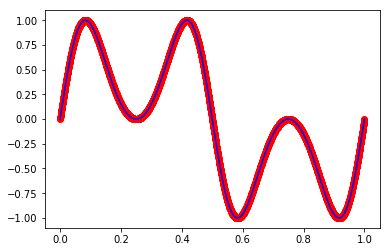

In [ ]:
# ------------------------
# function to be projected
# ------------------------
fun = lambda xi1 : np.sin( np.pi*( np.sin(2.*np.pi*xi1) ) )

#-----------------
# Create the grid:
#-----------------
# side lengths of logical cube
L = 1.

# spline degree
p = 3   

# periodic boundary conditions (use 'False' if clamped)
bc = True

# errors:
before_max = 0.
before_L2  = 0.
before_L1  = 0.

# loop over different number of elements (convergence test)
Nel_cases = [8, 16, 32, 64, 128, 256, 512]

# loop over different number of quadrature points per element
Nq_cases = [6]

for Nel in Nel_cases:
    
    print('Nel=', Nel)
    
    # element boundaries
    el_b = np.linspace(0., L, Nel + 1) 

    # knot sequences
    T = bsp.make_knots(el_b, p, bc)
    
    for Nq in Nq_cases:

        # create an instance of the projector class
        obj = proj_glob.projectors_1d(T, p, bc, Nq)

        # compute coefficients
        #coeffs = obj.PI_0(fun)
        coeffs = obj.PI_1(fun)

        # grid points for error computation
        pts_loc, wts_loc = np.polynomial.legendre.leggauss(6)   

        pts, wts = bsp.quadrature_grid(el_b, pts_loc, wts_loc)    

        xgrid = pts.flatten()   # error grid

        # projection evaluated at the grid points
        f_h = eva.FEM_field_1d(coeffs, 1, xgrid, T, p, bc)

        # function evaluated at the grid points
        f   = fun( xgrid )

        # max-norm
        err_max = np.max( np.abs(f - f_h) )

        # L2-norm
        err_L2 = np.sqrt( np.sum( np.abs(f - f_h)**2 ) / np.size(f) )

        # L1-norm
        err_L1 = np.sum( np.abs(f - f_h) ) / np.size(f) 

        # print errors
        print( 'Nq=', Nq, 
               '{:10.7f}'.format(err_max), '{:10.7f}'.format(before_max/err_max), ' | ',
               '{:10.7f}'.format(err_L2),  '{:10.7f}'.format(before_L2/err_L2),   ' | ', 
               '{:10.7f}'.format(err_L1),  '{:10.7f}'.format(before_L1/err_L1),   ' | ')

        before_max = err_max
        before_L2  = err_L2
        before_L1  = err_L1
        
    #print('')
    
    
plt.plot(xgrid, f_h, 'ro', xgrid, f, 'b-')

## Global projectors in 3D 

In [4]:

# ------------------------
# function to be projected
# ------------------------
fun = lambda xi1, xi2, xi3 : np.sin( np.pi*( np.sin(2.*np.pi*xi1)
                                            *np.sin(2.*np.pi*xi2)
                                            *np.sin(2.*np.pi*xi3) ) )
#-----------------
# Create the grid:
#-----------------
# side lengths of logical cube
L = [3., 2., 1.] 

# spline degrees
p = [3, 3, 3]   

# periodic boundary conditions (use 'False' if clamped)
bc = [True, True, True] 

# number of quadrature points per element
Nq_k = 6

# ------------------------
# loop over projector to test (0, 11, 12, 13, 21, 22, 23, 3):
# ------------------------
comp_cases = [0,11,12,13,21,22,23,3]


# loop over different number of elements (convergence test)
Nel_cases = [2**n for n in range(2,4)]

for comp in comp_cases:
    
    print('which projector=', comp)
    # errors:
    before_max = 0.
    before_L2  = 0.
    before_L1  = 0.

    before_max_fastV3 = 0.
    before_L2_fastV3  = 0.
    before_L1_fastV3  = 0.
    
    for Nel_k in Nel_cases:
    
        # number of elements
        Nel = [3*Nel_k, 2*Nel_k, Nel_k]   
        print('Nel=', Nel)


        # element boundaries
        el_b = [np.linspace(0., L_i, Nel_i + 1) for L_i, Nel_i in zip(L, Nel)] 

        # knot sequences
        T = [bsp.make_knots(el_b_i, p_i, bc_i) for el_b_i, p_i, bc_i in zip(el_b, p, bc)] 
    
        # number of quadrature points per element
        Nq = [Nq_k, Nq_k, Nq_k]

        # create an instance of the projector class
        obj      = proj_glob.projectors_3d(T, p, bc, Nq)
        obj_fastV3 = proj_glob_fastV3.projectors_3d(T, p, bc, Nq)
    

        # ---------------------------------------------
        # create LU decomposition of necessary matrices
        # ---------------------------------------------
        if comp==0:
            obj.NNN_LU()   # for PI_0  
        elif comp==11:
            obj.DNN_LU()  # for PI_11
        elif comp==12:
            obj.NDN_LU()  # for PI_12 
        elif comp==13:
            obj.NND_LU()  # for PI_13
        elif comp==21:
            obj.NDD_LU()  # for PI_21
        elif comp==22:
            obj.DND_LU()  # for PI_22
        elif comp==23:
            obj.DDN_LU()  # for PI_23
        elif comp==3:
            obj.DDD_LU()  # for PI_3

        # --------------------
        # compute coefficients
        # --------------------
        t0 = time.time()
        
        if comp==0:
            coeffs = obj.PI_0(fun)
        elif comp==11:
            coeffs = obj.PI_11(fun)
        elif comp==12:
            coeffs = obj.PI_12(fun)
        elif comp==13:
            coeffs = obj.PI_13(fun)
        elif comp==21:
            coeffs = obj.PI_21(fun)
        elif comp==22:
            coeffs = obj.PI_22(fun)
        elif comp==23:
            coeffs = obj.PI_23(fun)
        elif comp==3:
            coeffs = obj.PI_3(fun)
            
        t1 = time.time()
        print('time, original  =     %10.7e' % (t1-t0))
        t0 = time.time()
        
        mat_f = obj_fastV3.eval_for_PI(comp,fun)
        

        t1 = time.time()
        dt = t1-t0
        t0 = time.time()
        coeffs_fastV3 = obj_fastV3.PI_mat(comp, mat_f  )

        t1 = time.time()
        print('time_fastV3, eval + integrate & project, %10.7e + %10.7e = %10.7e' % (dt,(t1-t0),dt+(t1-t0)))
        print('post processing...')
        
        #print('size of mat_f in MB:', getsizeof( obj_fast.eval_for_PI_21(fun) )*1e-6)

        # grid points for error computation
        pts_loc, wts_loc = np.polynomial.legendre.leggauss(5)   # quadrature points per element

        pts1, wts1 = bsp.quadrature_grid(el_b[0], pts_loc, wts_loc)   
        pts2, wts2 = bsp.quadrature_grid(el_b[1], pts_loc, wts_loc) 
        pts3, wts3 = bsp.quadrature_grid(el_b[2], pts_loc, wts_loc) 

        xgrid = [ pts1.flatten(), pts2.flatten(), pts3.flatten() ]   # error grid
        
        # projection evaluated at the grid points

        t0 = time.time()
        f_basemat= evaV2.FEM_evalbase_3d(comp, xgrid, T, p, bc)
        t1 = time.time()
        print('time, eval FEM base V2  =     %10.7e' % (t1-t0))
        t0 = time.time()
        f_h      = kron_matvec_3d(f_basemat,coeffs)
        f_h_fastV3 = kron_matvec_3d(f_basemat,coeffs_fastV3)
        t1 = time.time()
        print('time, eval 2xFEM fields V2=     %10.7e' % (t1-t0))
        
        t0 = time.time()
        # exact function evaluated at the grid points
        f = np.empty((xgrid[0].size, xgrid[1].size, xgrid[2].size))
        
        pts_1,pts_2,pts_3=np.meshgrid(xgrid[0],xgrid[1],xgrid[2],indexing='ij',sparse=True)
        f = fun(pts_1,pts_2,pts_3)
        t1 = time.time()
        print('time, eval exact func  =     %10.7e' % (t1-t0))
        
        # max-norm
        err_max        = np.max( np.abs(f - f_h) )
        err_max_fastV3 = np.max( np.abs(f - f_h_fastV3) )
        
        # L2-norm
        err_L2      = np.sqrt( np.sum( np.abs(f - f_h)**2 ) / np.size(f) )
        err_L2_fastV3 = np.sqrt( np.sum( np.abs(f - f_h_fastV3)**2 ) / np.size(f) )

        # L1-norm
        err_L1      = np.sum( np.abs(f - f_h) ) / np.size(f) 
        err_L1_fastV3 = np.sum( np.abs(f - f_h_fastV3) ) / np.size(f)

        # print errors
        print( 'orig,  Nq=', Nq,
               '{:10.7f}'.format(err_max), '{:10.7f}'.format(before_max/err_max), ' | ',
               '{:10.7f}'.format(err_L2),  '{:10.7f}'.format(before_L2/err_L2),   ' | ', 
               '{:10.7f}'.format(err_L1),  '{:10.7f}'.format(before_L1/err_L1),   ' | ')
        
        print( 'fastV3,Nq=', Nq,
               '{:10.7f}'.format(err_max_fastV3), '{:10.7f}'.format(before_max_fastV3/err_max_fastV3), ' | ',
               '{:10.7f}'.format(err_L2_fastV3),  '{:10.7f}'.format(before_L2_fastV3/err_L2_fastV3),   ' | ', 
               '{:10.7f}'.format(err_L1_fastV3),  '{:10.7f}'.format(before_L1_fastV3/err_L1_fastV3),   ' | ')

        before_max = err_max
        before_L2  = err_L2
        before_L1  = err_L1
        
        before_max_fastV3 = err_max_fastV3
        before_L2_fastV3  = err_L2_fastV3
        before_L1_fastV3  = err_L1_fastV3        
        print('done.')
        
    print('')

which projector= 0
Nel= [12, 8, 4]
time, original  =     1.9853115e-03
time_fastV3, eval + integrate & project, 1.4662743e-04 + 2.6392937e-04 = 4.1055679e-04
post processing...
time, eval FEM base V2  =     5.5148602e-03
time, eval 2xFEM fields V2=     5.8197975e-04
time, eval exact func  =     8.7070465e-04
orig,  Nq= [6, 6, 6]  0.9999909  0.0000000  |   0.5242405  0.0000000  |   0.3959012  0.0000000  | 
fastV3,Nq= [6, 6, 6]  0.9999909  0.0000000  |   0.5242405  0.0000000  |   0.3959012  0.0000000  | 
done.
Nel= [24, 16, 8]
time, original  =     1.4793634e-02
time_fastV3, eval + integrate & project, 2.3722649e-04 + 1.9598007e-04 = 4.3320656e-04
post processing...
time, eval FEM base V2  =     9.9651814e-03
time, eval 2xFEM fields V2=     3.6740303e-03
time, eval exact func  =     8.0087185e-03
orig,  Nq= [6, 6, 6]  0.3198655  3.1262854  |   0.0818382  6.4058155  |   0.0545954  7.2515527  | 
fastV3,Nq= [6, 6, 6]  0.3198655  3.1262854  |   0.0818382  6.4058155  |   0.0545954  7.2515527 